In [7]:
import numpy as np
import pandas as pd 

import tensorflow
from tensorflow import keras
from keras.layers import Dense, Flatten
from keras import Sequential
from keras.utils import load_img, img_to_array, array_to_img
from keras.applications.vgg16 import VGG16,preprocess_input, decode_predictions

In [8]:
model = VGG16(weights = 'imagenet')

In [9]:
img = load_img('/kaggle/input/cylinde/cy.jpg', target_size = (224, 224))
img_array = img_to_array(img)
x = np.expand_dims(img_array, axis = 0)
print(x.shape)
x = preprocess_input(x)

(1, 224, 224, 3)


In [10]:
preds = model.predict(x)
decode_predictions(preds, top = 3)

1/1 [==============================] - 0s 150ms/step


[[('n02397096', 'warthog', 1.0),
  ('n02319095', 'sea_urchin', 0.0),
  ('n02395406', 'hog', 0.0)]]

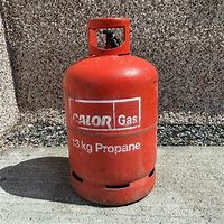

In [6]:
img

# Transfer Learning

In [11]:
base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150, 150, 3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [13]:
model1 = Sequential()
model1.add(base)
model1.add(Flatten())
model1.add(Dense(256, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [15]:
base.trainable = False #Freezing the base

In [16]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150, 150)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150, 150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [17]:
#Normalize
def process(image, label):
    image = tensorflow.cast(image/255, tensorflow.float32)
    return image, label

train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

In [18]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
history = model1.fit(train_ds, epochs = 5, validation_data = test_ds)

Epoch 1/5
625/625 [==============================] - 40s 64ms/step - loss: 0.0676 - accuracy: 0.9748 - val_loss: 0.4021 - val_accuracy: 0.8840
Epoch 2/5
625/625 [==============================] - 39s 63ms/step - loss: 0.0470 - accuracy: 0.9851 - val_loss: 0.3892 - val_accuracy: 0.8900
Epoch 3/5
625/625 [==============================] - 43s 68ms/step - loss: 0.0357 - accuracy: 0.9877 - val_loss: 0.4296 - val_accuracy: 0.8900
Epoch 4/5
625/625 [==============================] - 37s 58ms/step - loss: 0.0345 - accuracy: 0.9882 - val_loss: 0.4958 - val_accuracy: 0.8848
Epoch 5/5
625/625 [==============================] - 38s 61ms/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 0.5270 - val_accuracy: 0.8914


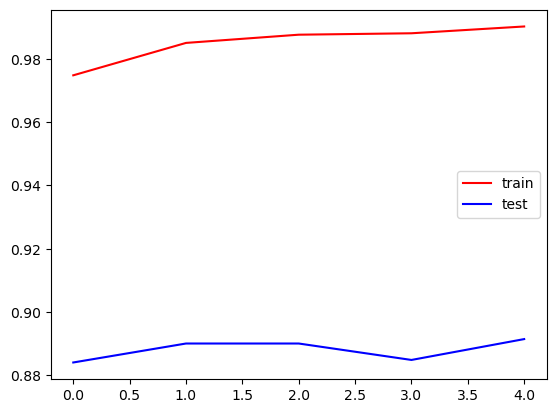

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'test')
plt.legend()
plt.show()

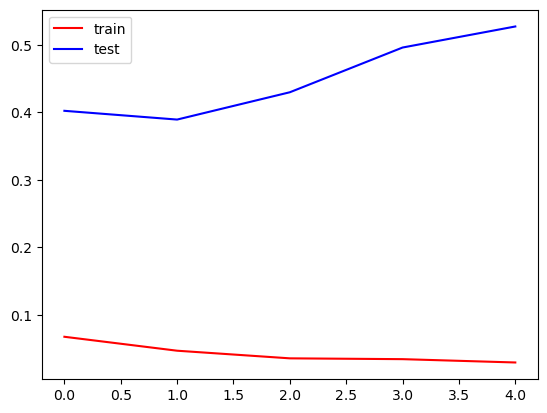

In [24]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'test')
plt.legend()
plt.show()

# Adding Data Augumentation to reduce Overfitting

In [21]:
from keras.preprocessing.image import ImageDataGenerator

In [36]:
batch_size = 32

datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2
)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_ds = datagen.flow_from_directory(
    '/kaggle/input/dogs-vs-cats/train',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary'
)

test_ds = test_datagen.flow_from_directory(
    '/kaggle/input/dogs-vs-cats/test',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [37]:
conv_base = VGG16(weights = 'imagenet', input_shape = (150, 150, 3), include_top = False)
conv_base.trainable = False

In [38]:
model2 = Sequential()

model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy')

In [39]:
history = model2.fit(train_ds, epochs = 5, validation_data = test_ds)

Epoch 1/5
625/625 [==============================] - 146s 231ms/step - loss: 0.3302 - accuracy: 0.8543 - val_loss: 0.2559 - val_accuracy: 0.8910
Epoch 2/5
625/625 [==============================] - 142s 228ms/step - loss: 0.2643 - accuracy: 0.8860 - val_loss: 0.2547 - val_accuracy: 0.8908
Epoch 3/5
625/625 [==============================] - 142s 228ms/step - loss: 0.2488 - accuracy: 0.8921 - val_loss: 0.2299 - val_accuracy: 0.9030
Epoch 4/5
625/625 [==============================] - 144s 230ms/step - loss: 0.2293 - accuracy: 0.8999 - val_loss: 0.2464 - val_accuracy: 0.8994
Epoch 5/5
625/625 [==============================] - 144s 230ms/step - loss: 0.2219 - accuracy: 0.9038 - val_loss: 0.2372 - val_accuracy: 0.9010


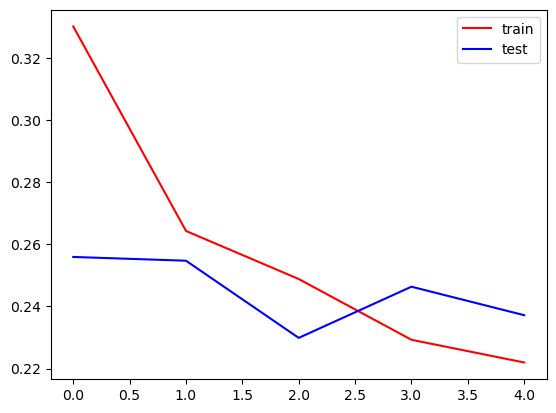

In [40]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'test')
plt.legend()
plt.show()

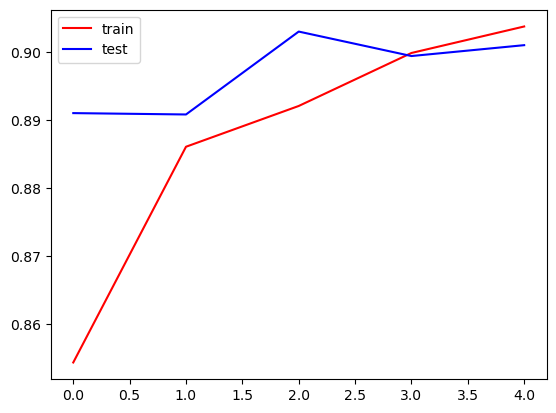

In [41]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'test')
plt.legend()
plt.show()